# Introduksjon til clustering
Begrepet "clustering" betyr direkte oversatt "klynging". Når vi jobber med et datasett med mange observasjoner, kan vi tenke oss at noen av observasjonene ligner mye på hverandre - de er en "klynge" av ganske like observasjoner. Kanskje finnes det en naturlig _struktur_ i datasettet med flere slike klynger, uten at vi på forhånd vet hvilke observasjoner som tilhører hvilken klynge. 

I denne modulen skal vi se på en konkret algoritme, "[K-means](https://en.wikipedia.org/wiki/K-means_clustering)", som kan brukes for å automatisk oppdage slike klynger, og å si hvilke punkter som tilhører hvilken klynge. Men for å lage denne må vi først lage noen "byggeblokker". Vi må se på hvordan datasettet kan representeres som punkter i et rom. For å gjøre det bruker vi et eksempel-datasett fra 2014 som beskriver observasjoner av pingviner i Antarktis.

In [1]:
# Imports
import numpy as np                  # For vectors and matrices
import sklearn.datasets             # For creating test clusters
import sklearn.metrics              # For validating clustering results
import matplotlib.pyplot as plt     # For plotting data points and clusters
import clustering as clst  
import csv

<img src="https://github.com/allisonhorst/palmerpenguins/blob/main/man/figures/lter_penguins.png?raw=true" alt="Drawing" style="width: 600px;"/>


## Formatering av datasett og matematiske definisjoner
I arbeidet med clustering skal vi introdusere litt mer matematikk enn hva vi har gjort tidligere. Vi antar her at våre datasett består av kun numeriske data. Vi antar også at ingen av disse er kategorier som har blitt "kodet" som numeriske data. Som et eksempel kan vi ta et utdrag fra datasettet "Palmer Penguins":

|Culmen length (mm)|Culmen depth (mm)|Flipper length (mm)|Body mass (g)|
|------------------|-----------------|-------------------|-------------|
|39.1|18.7|181|3750|
|39.2|19.6|195|4675|
|34.1|18.1|193|3475|
|42.0|20.2|190|4250|
|50.9|19.1|196|3550|
|45.5|17.0|196|3500|
|49.8|16.8|230|5700|
|46.2|14.4|214|4650|

<img src="https://github.com/allisonhorst/palmerpenguins/blob/main/man/figures/culmen_depth.png?raw=true" alt="Drawing" style="width: 400px;"/>
   
Hver rad i dette datasettet utgjør en observasjon av en enkelt, konkret pingvin. En observasjon kalles også et "sample". For hver av de åtte pingvinene har man målt 4 ulike ting: Lengde og "dybde" på nebbet, lengde på vingene, og vekten. Vi har altså 4 "features".

Vi kan betrakte datasettet vårt som en $M$ x $N$-matrise, der $M$ er antallet rader og $N$ er antallet kolonner (features). I eksempelet med pingvinene er $M$=8 og $N$=4.

$$
X = \begin{bmatrix}
        39.1&18.7&181&3750 \\
        39.2&19.6&195&4675 \\
        34.1&18.1&193&3475 \\
        42.0&20.2&190&4250 \\
        50.9&19.1&196&3550 \\
        45.5&17.0&196&3500 \\
        49.8&16.8&230&5700 \\
        46.2&14.4&214&4650 \\
    \end{bmatrix}
$$

Vi anser hver obserasjon som en vektor med $N$ elementer. Dette tilsvarer et "datapunkt" i et $N$-dimensjonalt rom:

$$\vec{x} = [x_0,x_1,...,x_{N-1}]$$

Merk at vi bruker 0-indeksering her for å være konsistent med Python-indeksering. Vi kan da anse X-matrisa som et sett med $M$ radvektorer:

$$
X = \begin{bmatrix}
        \vec{x}_0 \\
        \vec{x}_1 \\
        ... \\
        \vec{x}_{M-1}
    \end{bmatrix}

  = \begin{bmatrix}
        x_{0,0} & x_{0,1} & ... & x_{0,N-1} \\
        x_{1,0} & x_{1,1} & ... & x_{1,N-1} \\
        ... & ... & ... & ... \\
        x_{M-1,0} & x_{M-1,1} & ... & x_{M-1,N-1} \\
    \end{bmatrix}
$$

Første og siste vektor for pingvin-datasettet vårt blir da:
$$ \vec{x}_0 = [39.1,18.7,181,3750]$$
$$ \vec{x}_7 = [46.2,14.4,214,4650]$$


## Distanse mellom datapunkter
Vi skal komme tilbake til pingvinene litt senere, men inntil videre skal vi se på punkter i et 2-dimensjonalt rom. I praktisk maskinlæring har man ofte mer enn 2 features, men disse kan være vanskelige å visualisere. Gjennom å begrense oss til 2 features kan vi plotte datapunktene våre som punkter på en 2-dimensjonal flate.

La oss anta at vi har punktene $\vec{x}_0 = [2,1]$ og $\vec{x}_1 = [3,4]$. Vi kan plotte disse ved hjelp av matplotlib:

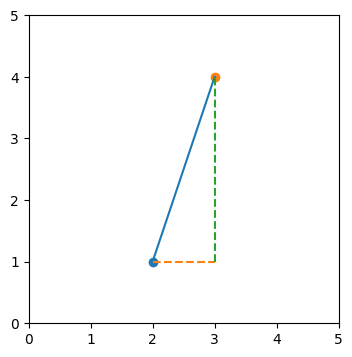

In [2]:
x0 = np.array([2,1])
x1 = np.array([3,4])
_ = plt.figure(figsize=(4,4))
plt.scatter(x0[0],x0[1])                   # "Dot" indicating x0
plt.scatter(x1[0],x1[1])                   # "Dot" indicating x1
plt.plot((x0[0],x1[0]),(x0[1],x1[1]))      # Line between points
plt.plot((x0[0],x1[0]),(x0[1],x0[1]),'--')    # Horizontal side of triangle
plt.plot((x1[0],x1[0]),(x0[1],x1[1]),'--')    # Vertical side of triangle

plt.xlim((0,5))
plt.ylim((0,5))
plt.show()

Hvis vi vil vite avstanden mekllom de to punktene, det vil si lengden på streken mellom dem, kan vi bruke Pythagoras' teorem. Avstanden mellom punktene tilsvarer hypotenusen i en rettvinklet trekant, der siden av trekanten tilsvarer forskjellen i horisontal og vertikal posisjon:
$$ d = \sqrt{(3-2)^2 + (4-1)^2} = \sqrt{10} = 3.162$$

Kanskje har du også gjort tilsvarende beregninger av avstand i 3 dimensjoner. Uttrykket er likt, med unntak av at man også inkluderer forskjellen i posisjon langs den 3. dimensjonen. Vi kan generalisere avstands-begrepet og definere [Euklidsk avstand](https://en.wikipedia.org/wiki/Euclidean_distance) i N dimensjoner. Avstanden mellom to vektorer $\vec{a}$ og $\vec{b}$ er gitt ved.
$$d(\vec{a},\vec{b}) = \sqrt{\sum_i (b_i-a_i)^2} = \sqrt{(b_0-a_0)^2 + (b_1-a_1)^2 + ... + (b_{N-1}-a_{N-1})^2}$$

Hvis vi for eksempel har to vektorer i et 4-dimensjonalt rom, kan vi beregne avstanden mellom dem slik:
$$ \vec{a} = [5,3,6,6] $$
$$ \vec{b} = [4,-1,2,7] $$
$$ d(\vec{a},\vec{b}) = \sqrt{(4-5)^2 + ((-1)-3)^2 + (2-6)^2 + (7-6)^2} = \sqrt{34} = 5.83

**Første oppgave i innleveringen er å implementere en funksjon distance() som beregner avstanden mellom to vektorer på denne måten.**

## Finne nærmeste punkt blant mange
Neste byggeblokk i algoritmen vår er at vi skal lete etter hvilket punkt (blant mange) som ligger _nærmest_ et gitt punkt. Anta at vi har et datapunkt $\vec{x} = [x_0,x_1,...,x_{N-1}] $, og en matrise ${C}$ gitt ved

$$\bm{C} = \begin{bmatrix} \vec{c}_0 \\ \vec{c}_1 \\ ... \\ \vec{c}_{k-1} \end{bmatrix} =
\begin{bmatrix} 
c_{0,0} & c_{0,1} & ... & c_{0,N-1} \\ 
c_{1,0} & c_{1,1} & ... & c_{1,N-1} \\ 
... & ... & ... & ... \\ 
c_{k-1,0} & c_{k-1,1} & ... & c_{k-1,N-1}
\end{bmatrix}$$

Hver rad i $C$ tilsvarer en vektor $\vec{c}_i$. Hver av disse vektorene har like mange elementer som $\vec{x}$ (dvs. $N$), og det er $k$ vektorer i alt. $C$ inneholder altså $k$ datapunkter. Datapunktet i $C$ som ligger _nærmest_ $x$ er gitt ved 

$$\bm{c}_{\text{closest}} = \underset{\bm{c}_i}{\mathrm{argmin}} \ d(\bm{x},\bm{c_i})$$

altså vektoren $\vec{c}_i$ som har lavest distanse relativt til $\vec{x}$. Vi kan demonstrere dette med et eksempel:


x=array([[-0.8,  0.7]])
C=array([[-1.9250645 , -3.01879523],
       [ 1.15446315,  1.56278191],
       [ 1.32951737, -0.4295925 ],
       [-0.07288832, -0.29154696],
       [ 1.36824268,  0.87196735],
       [ 0.05837772,  0.70812363],
       [ 1.36030603,  0.37452505],
       [-1.08551679, -0.07479491],
       [-0.42665655, -1.59184729],
       [-2.04585646,  0.14871256]])


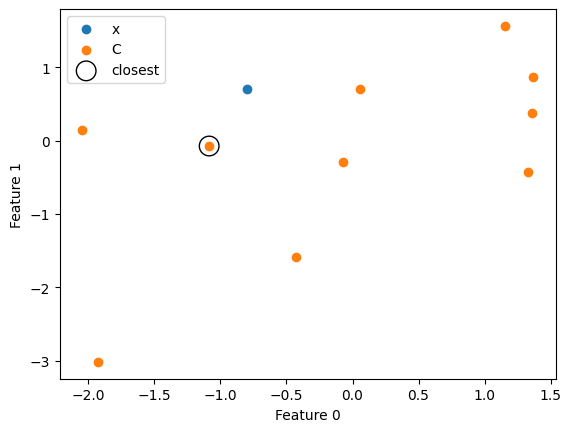

In [3]:
# Create x and C
x = np.array([[-0.8, 0.7]])
print(f'{x=}')

rng = np.random.default_rng(seed=26)
C = rng.multivariate_normal(mean=(0,0),cov=((1,0),(0,1)),size=10)
print(f'{C=}')

plt.scatter(x[:,0],x[:,1],label='x')
plt.scatter(C[:,0],C[:,1],label='C')
plt.scatter(C[7,0],C[7,1], marker='o', s=200, facecolors='none', edgecolors='k', label='closest')
plt.legend()
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.show()

Her ser vi at vi har 10 punkter i $C$, vist i orange. Punktet $\vec{x}$ er vist i blått. Punktet i $C$ som ligger nærmest $\vec{x}$ er indikert med en svart ring. Dette tilsvarer $\vec{c}_7$, altså rad 7 i $C$.

**Din neste oppgave i innleveringen er å lage en funksjon closest_point_index() som finner indeksen til nærmeste punkt, på samme måte som i eksempelet over.**

## Eksempel på klynger
Begrepet "clustering" betyr altså "klynging", som nevnt tidligere. Vi kan tenke oss at observasjonene våre tilhører "klynger" av punkter i det N-dimensjonale rommet, der punktene i samme klynge ligger nært hverandre. Vi kan lage et enkelt eksempel-datasett som viser dette:

In [4]:
X_clusters,_ = sklearn.datasets.make_blobs(centers=np.array([[0,0],[2,1],[1,2]]),
                                           n_samples = 30, 
                                           cluster_std=0.2,
                                           random_state=42)
print(X_clusters)

[[ 0.97687034  1.93977926]
 [ 1.14769332  2.03427366]
 [-0.20256622  0.06284947]
 [ 0.31584256  0.15348695]
 [-0.09268354 -0.09314595]
 [ 1.06625269  2.19510903]
 [ 1.89112346  1.02218452]
 [ 1.2061999   2.18625602]
 [ 2.29312975  0.95484474]
 [ 0.04839245 -0.38265605]
 [-0.18160482 -0.28246074]
 [ 1.99730056  0.78845781]
 [ 2.04177272  0.60806598]
 [ 2.16450898  0.75583127]
 [ 1.76980128  1.0751396 ]
 [ 1.87987226  0.94166125]
 [ 1.06872366  1.64739197]
 [ 1.73436279  1.03937225]
 [ 0.8321565   1.93815752]
 [ 1.06481679  1.92298354]
 [-0.34498357 -0.11245751]
 [ 2.01350564  0.71505036]
 [-0.04683067 -0.04682739]
 [-0.09389488  0.10851201]
 [ 0.90787225  2.21142445]
 [ 0.8646156   2.12233526]
 [ 0.7042956   1.85603116]
 [ 1.87965868  1.37045564]
 [ 0.09934283 -0.02765286]
 [ 0.12953771  0.30460597]]


Det er kanskje ikke så lett å se noen klynger direkte, men hvis vi plotter disse punktene, blir det lettere. Vi plotter da verdiene i første kolonne langs x-aksen, og verdiene i andre kolonne langt y-aksen.

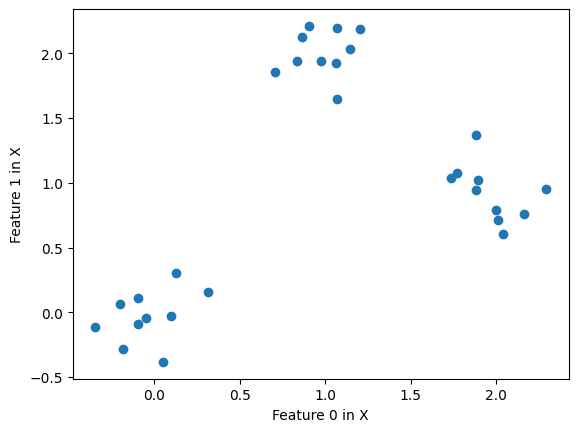

In [5]:
plt.scatter(X_clusters[:,0],X_clusters[:,1])    
plt.xlabel('Feature 0 in X')
plt.ylabel('Feature 1 in X')
plt.show()

Nå ser vi tydeligere at vi har tre klynger: En nederst til venstre, sentrert rundt koordinat (0,0), en oppe i midten, sentrert rundt koordinat (1,2), og en siste til høyre, sentrert rundt (2,1). I k-means-algoritmen vi skal lage, skal vi prøve å estimere "sentrene" i de ulike klyngene. På engelsk bruker man begrepet "centroids" om disse sentrene, som gjerne oversettes til "geometrisk sentrum" - men i teksten videre bruker vi ordet "tyngdepunkt".

## Velge tilfeldige punkter
K-means-algoritmen er en _iterativ_ algoritme som gradvis prøver å finne bedre estimater for tyngdepunktene til de ulike klyngene. Men når algoritmen starter, har vi ingen idé om hva disse er. For å ha et utgangspunkt å jobbe videre med, plukker vi da noen tilfeldige punkter fra datasettet vårt. 

_Merk: Vi er nødt til å gjøre en antagelse angående hvor mange klynger vi har ($k$)._ Dette er en input-parameter til algoritmen.

Under er et eksempel med "manuell" utvelgelse av $k$ tilfeldige punkter fra en $X$-matrise. I en generell løsning må lage kode som kan generere tilfeldige indekser. Punktene må velges _uten tilbakelegging_ (dvs. ingen punkter er duplikater av hverandre).

In [6]:
random_indices = [16,3,25]   # 3 indices, corresponds to k=3
C = X_clusters[random_indices,:]

print(f'{X_clusters=}')
print(f'{C=}')


X_clusters=array([[ 0.97687034,  1.93977926],
       [ 1.14769332,  2.03427366],
       [-0.20256622,  0.06284947],
       [ 0.31584256,  0.15348695],
       [-0.09268354, -0.09314595],
       [ 1.06625269,  2.19510903],
       [ 1.89112346,  1.02218452],
       [ 1.2061999 ,  2.18625602],
       [ 2.29312975,  0.95484474],
       [ 0.04839245, -0.38265605],
       [-0.18160482, -0.28246074],
       [ 1.99730056,  0.78845781],
       [ 2.04177272,  0.60806598],
       [ 2.16450898,  0.75583127],
       [ 1.76980128,  1.0751396 ],
       [ 1.87987226,  0.94166125],
       [ 1.06872366,  1.64739197],
       [ 1.73436279,  1.03937225],
       [ 0.8321565 ,  1.93815752],
       [ 1.06481679,  1.92298354],
       [-0.34498357, -0.11245751],
       [ 2.01350564,  0.71505036],
       [-0.04683067, -0.04682739],
       [-0.09389488,  0.10851201],
       [ 0.90787225,  2.21142445],
       [ 0.8646156 ,  2.12233526],
       [ 0.7042956 ,  1.85603116],
       [ 1.87965868,  1.37045564],
       [ 

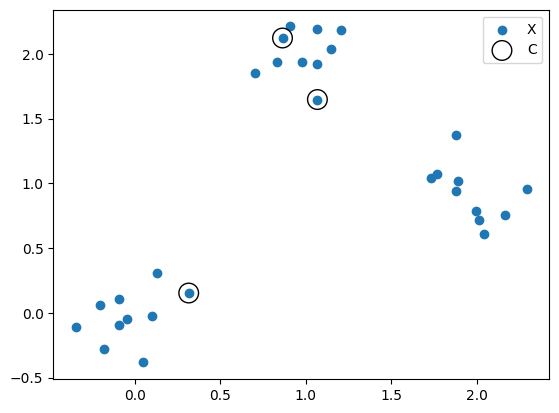

In [7]:
plt.scatter(X_clusters[:,0],X_clusters[:,1],label='X')
plt.scatter(C[:,0],C[:,1],marker='o', s=200, facecolors='none', edgecolors='k',label='C')
plt.legend()
plt.show()

**Neste oppgave i innleveringa er å implementere en funksjon choose_random_points() som velger $k$ forskjellige punkter fra ei matrise.**

## Finne nærmeste tyngdepunkt
Vi tenker nå at punktene som vi har valgt ut i $C$ tilsvarer er våre estimeter for tyngdepunktene i tre ulike klynger. For å finne ut hvilke punkter som tilhører hvilken klynge, må vi gå gjennom alle punktene våre, og sjekke hvilket av tyngdepunktene som ligger nærmest. Her er pseudokode for denne prosessen:

    la y være et array med lengde M ("label-array")
    for hvert datapunkt x_i i X:
        minste_distanse = "uendelig" (evt. veldig stor)
        for hvert tyngdepunkt c_j i C:
            d = distanse(x_i,c_j)
            hvis d < minste_distanse:
                minste_distanse = d
                y_i = j

Kodesnutten under viser resultatet av dette "søket" etter de nærmeste punktene. Listene "closest_0", "closest_1" og "closest_2" inneholder indeksene til punktene i $X$ som er nærmest henholdsvis $\vec{c}_0$, $\vec{c}_1$, og $\vec{c}_2$ i $C$.

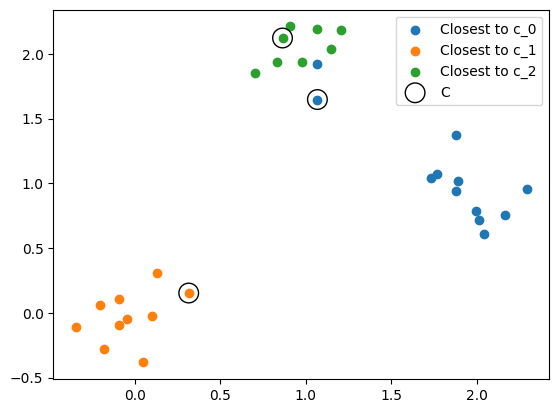

In [8]:
closest_0 = [ 6,  8, 11, 12, 13, 14, 15, 16, 17, 19, 21, 27]
closest_1 = [ 2,  3,  4,  9, 10, 20, 22, 23, 28, 29]
closest_2 = [ 0,  1,  5,  7, 18, 24, 25, 26]

plt.scatter(X_clusters[closest_0,0],X_clusters[closest_0,1],label = 'Closest to c_0')
plt.scatter(X_clusters[closest_1,0],X_clusters[closest_1,1],label = 'Closest to c_1')
plt.scatter(X_clusters[closest_2,0],X_clusters[closest_2,1],label = 'Closest to c_2')
plt.scatter(C[:,0],C[:,1],marker='o', s=200, facecolors='none', edgecolors='k',label='C')

plt.legend()
plt.show()


Punktene som er nærmest tyngepunkt $\vec{c}_0$ er farget blå, punktene som er nærmest tyngepunkt $\vec{c}_1$ er farget orange, og punktene som er nærmest tyngepunkt $\vec{c}_2$ er grønne. De tre tyngdepunktene (som altså er tre tilfeldig utvalgte punkter) er indikert med svart ring. 

**Neste oppgave i innleveringen er å implementere en funksjon find_closest_centroid() som returnerer indeks til nærmeste tyngdepunkt**.

## Oppdatering av tyngdepunkt
Du legger kanskje merke til at "fargeleggingen" av punktene i plottet tilsvarer en nesten perfekt "merking" av de tre ulike klyngene i datasettet? Alle punktene i klyngen nederst til venstre er orange, og alle punktene i klyngen til høyre er blå. I den øverste klyngen er de fleste punktene grønne, men et par punkter er blå. Dette er riktignok et "lett" datasett, og vi var litt heldige, men vi kan se at vi er på god vei til å identifisere alle klyngene.

Nå kommer et genialt punkt i algoritmen: Vi kan _oppdatere_ vårt estimat for tyngdepunktene i hver klynge. For å gjøre det, tar vi for oss alle punktene som ligger nærmest vårt opprinnelige tyngdepunkt, og finner _gjennomsnittsverdien_ av disse. Dette utgjør vårt nye estimat for tyngepunktet. 

In [9]:
C_new = np.zeros(C.shape)
C_new[0,:] = np.mean(X_clusters[closest_0,:],axis=0)
C_new[1,:] = np.mean(X_clusters[closest_1,:],axis=0)
C_new[2,:] = np.mean(X_clusters[closest_2,:],axis=0)
print(C)

[[1.06872366 1.64739197]
 [0.31584256 0.15348695]
 [0.8646156  2.12233526]]


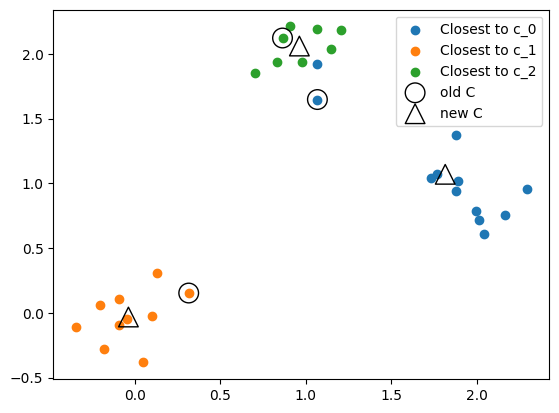

In [10]:
closest_0 = [ 6,  8, 11, 12, 13, 14, 15, 16, 17, 19, 21, 27]
closest_1 = [ 2,  3,  4,  9, 10, 20, 22, 23, 28, 29]
closest_2 = [ 0,  1,  5,  7, 18, 24, 25, 26]

plt.scatter(X_clusters[closest_0,0],X_clusters[closest_0,1],label = 'Closest to c_0')
plt.scatter(X_clusters[closest_1,0],X_clusters[closest_1,1],label = 'Closest to c_1')
plt.scatter(X_clusters[closest_2,0],X_clusters[closest_2,1],label = 'Closest to c_2')
plt.scatter(C[:,0],C[:,1],marker='o', s=200, facecolors='none', edgecolors='k',label='old C')
plt.scatter(C_new[:,0],C_new[:,1],marker='^', s=200, facecolors='none', edgecolors='k',label='new C')

plt.legend()
plt.show()

Hvis man nå finner hvilke punkter som ligger nærmest vår _oppdaterte_ versjon av tyngdepunktene (i matrisa $C$), kan vi se at vi får en perfekt inndeling i tre klynger:

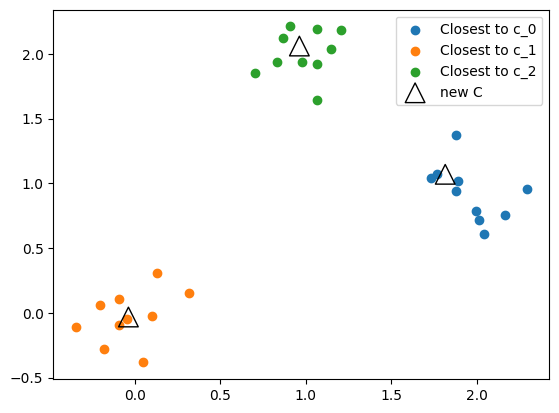

In [11]:
closest_0 = [ 6,  8, 11, 12, 13, 14, 15, 17, 21, 27]
closest_1 = [ 2,  3,  4,  9, 10, 20, 22, 23, 28, 29]
closest_2 = [ 0,  1,  5,  7, 16, 18, 19, 24, 25, 26]

plt.scatter(X_clusters[closest_0,0],X_clusters[closest_0,1],label = 'Closest to c_0')
plt.scatter(X_clusters[closest_1,0],X_clusters[closest_1,1],label = 'Closest to c_1')
plt.scatter(X_clusters[closest_2,0],X_clusters[closest_2,1],label = 'Closest to c_2')
plt.scatter(C_new[:,0],C_new[:,1],marker='^', s=200, facecolors='none', edgecolors='k',label='new C')

plt.legend()
plt.show()

Dette er kjernen i k-means-algoritmen: Man starter med et grovt estimat av tyngdepunkter for $k$ klynger, og oppdaterer dette estimatet iterativt. I vårt tilfelle trengte vi bare 1 iterasjon for å få en "perfekt" inndeling i klynger. Hvis vi gjør en iterasjon til, vil ikke inndelingen ("fargeleggingen") i de tre ulike gruppene endre seg, fordi de tilsvarende tyngdepunktene allerede ligger "inni" hver klynge. I andre datasett vil man trenge flere iterasjoner før man finner en stabil løsning.

**Neste oppgave i innleveringa er å implementere en funksjon kmeans_iteration() som gjennomfører en enkelt iterasjon: Gruppere datapunktene i $X$ ut fra hvilke hvilket tyngdepunkt i $C$ som ligger nærmest, og så beregne gjennomsnittet av hver gruppe for å estimere nye tyngdepunkter.**

## K-means pseudokode
Da har vi kommet nesten helt i mål - vi har implementert all kode som trengs for å å gjøre en enkelt iterasjon av K-means. Nå trenger vi bare rammeverket for å sette den opp og kjøre til den er ferdig - vi trenger en løkke som kjører inntil den når en sluttbetingelse. I vårt tilfelle kan vi sjekke om det skjer noen endring i $C$, som representerer tyngdepunktene. Hvis $C$ ikke har endret seg fra en iterasjon til den neste, har algoritmen nådd en stabil tilstand, og $C$ kommer ikke til å endre seg igjen. I tillegg kan det være greit å legge inn en "sikkerhetsventil" i form av et makimalt antall iterasjoner. Da unngår man at algoritmen kjører "i all evighet" hvis man har gjort en feil i koden, eller det er noe underlig med datasettet. Under finner du pseudokode for K-means-algoritmen.

    kmeans(X,k,maxiter):
        let (M,N) equal the shape of X
        let C equal a zero-filled matrix of shape (k,N)
        let C_next equal a kxN matrix with k randomly chosen (and unique) rows from X
        let count = 0

        while (C_next is not equal to C) and count < maxiter:
            increment count
            let C be equal to C_next
            let y,C_next be equal to kmeans_interation(X,C)
        
        return y,C

**Siste oppgave i innleveringa er å implementere K-means algoritmen som funksjonen kmeans().**

## Eksempel med clustering av pingvin-data
I resten av denne notebook'en skal vi ikke introdusere noen flere oppgaver eller nye konsepter knyttet til K-means, men vi skal se på anvendelse av K-means på mer realistiske data. Vi leser inn hele Palmer Penguins-datasettet, og bruker to "features" fra dette ("culmen length" og "culmen depth") for å lage vår X-matrise. Vi fortsetter å begrense antall dimensjoner til to for å kunne plotte datasettet enkelt. I tillegg bruker vi "species" som vår "fasit" - de tre ulike artene tilsvarer tre klasser som vi skal se om vi kan "oppdage" kun ved å se på lengde og høyde på nebbet til pingvinene.

In [12]:
# Read file
file_path = 'palmer_penguins.csv'
with open(file_path,'r',newline='') as file:
    csvreader = csv.reader(file)
    data = [row for row in csvreader]
header = data[0]
data = np.array(data[1:])

In [13]:
# Filter columns and remove "NA" rows
is_col = np.isin(header,['species','culmen_length_mm','culmen_depth_mm'])
data_filt = data[:,is_col]    
is_na = np.any(data_filt == 'NA',axis=1) # True if any element in row is NA
data_filt = data_filt[~is_na,:]

# Extract features
X = data_filt[:,1:].astype(float)  # Culmen length/depth

# Extract species and convert to numeric
y_text = data_filt[:,0]                 # 
y_unique = list(np.unique(y_text))
y = [y_unique.index(species) for species in y_text]  # Convert text to numbers

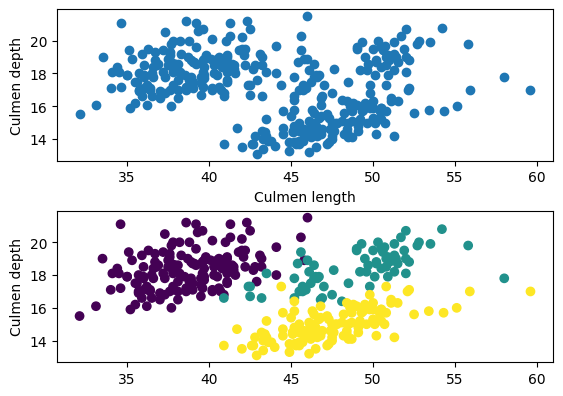

In [14]:
# Show features (without and with species labels)
fig,axs = plt.subplots(nrows=2)
axs[0].scatter(X[:,0],X[:,1])
axs[1].scatter(X[:,0],X[:,1],c=y)
for ax in axs:
    ax.set_aspect('equal')
    ax.set_ylabel('Culmen depth')
axs[0].set_xlabel('Culmen length')
plt.show()

In [15]:
# Run K-means
y_clust,C = clst.kmeans(X,3)

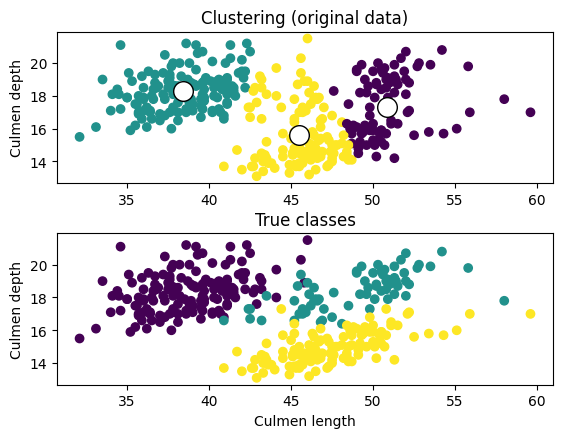

Homogeneity: 0.5537945531562943


In [16]:
# Plot result
fig,axs = plt.subplots(nrows=2)
axs[0].scatter(X[:,0],X[:,1],c=y_clust)
axs[0].scatter(C[:,0],C[:,1],marker='o', s=200,c='w',edgecolors='k')
axs[1].scatter(X[:,0],X[:,1],c=y)

for ax in axs:
    ax.set_aspect('equal')
    ax.set_ylabel('Culmen depth')
axs[1].set_xlabel('Culmen length')

axs[0].set_title('Clustering (original data)')
axs[1].set_title('True classes')
plt.show()
print(f'Homogeneity: {sklearn.metrics.homogeneity_score(y,y_clust)}')

Homogenitets-scoren forteller oss at inndelingen i 3 grupper fungerer "ikke så verst" - clustering gjør at litt over 50% av obserasjonene deles inn i henhold til hvilken art de tilhører. Men vi har et lite problem i datasettet som vi kan prøve å fikse: I de opprinnelige dataene er nemlig "culmen length"-dimensjonen "større". Culmen length varierer mellom cirka 30 og 60 mm, mens culmen depth varierer mellom cirka 12 og 22 mm. Det gjør at distanse-beregningene som brukes i K-means er dominert av culmen length. Hvis vi normaliserer begge målene (Z-score) vil distanse-beregningene bli mer balanserte, og begge features bidrar mer likt til K-means.

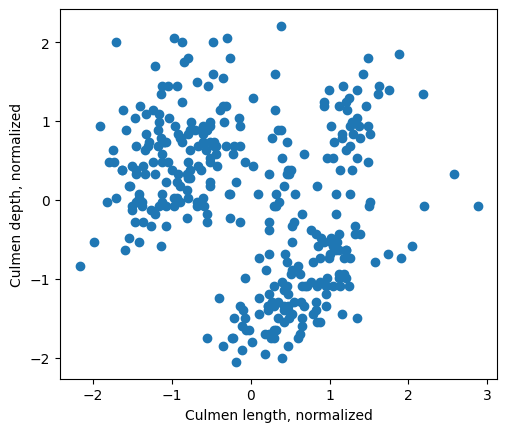

In [17]:
# Z-score normalization 
X_norm = (X-np.mean(X,axis=0)) / np.std(X,axis=0)
plt.scatter(X_norm[:,0],X_norm[:,1])
plt.gca().set_aspect('equal')
plt.xlabel('Culmen length, normalized')
plt.ylabel('Culmen depth, normalized')
plt.show()

In [18]:
# New K-means with normalized data
y_clust_norm,C_norm = clst.kmeans(X_norm,3)

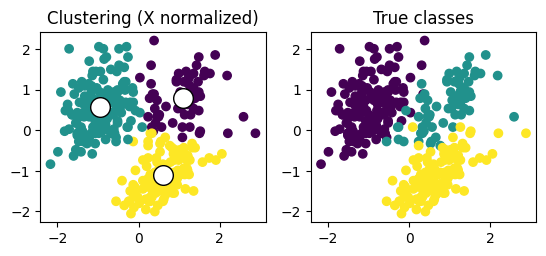

Homogeneity: 0.7429051582617074


In [19]:
# Plot clustering with normalized data
fig,axs = plt.subplots(ncols=2)
axs[0].scatter(X_norm[:,0],X_norm[:,1],c=y_clust_norm)
axs[0].scatter(C_norm[:,0],C_norm[:,1],marker='o', s=200,c='w',edgecolors='k')
axs[1].scatter(X_norm[:,0],X_norm[:,1],c=y)
axs[0].set_aspect('equal')
axs[1].set_aspect('equal')
axs[0].set_title('Clustering (X normalized)')
axs[1].set_title('True classes')
plt.show()
print(f'Homogeneity: {sklearn.metrics.homogeneity_score(y,y_clust_norm)}')

Vi ser at mer normalisering økte homogeniserings-scoren til cirka 75 % - slett ikke verst! Og ennå har vi bare brukt 2 av i alt 4 mulige numeriske features i datasettet. Hvis du er nysgjerrig kan du gjerne prøve å modifisere koden til også å inkludere "flipper_length" og "body mass", og se om du klarer å gjøre det enda bedre.

## Oppsummering 
K-means er et eksempel på unsupervised learning. Vi har sett at algoritmen lar oss "oppdage" strukturer i datasettet og automatisk dele observasjonene inn i $k$ kategorier, uten å ha noen "fasit" å lære fra. En viktig begrensning med algoritmen er at man på forhånd bør vite omtrent hvor mange klynger ($k$) man forventer å finne i datasettet.